# Piecewise Poisson problems

In [4]:
# Automatically reload modules
%load_ext autoreload
%autoreload 2

import torch
from hmpinn.differential_operators.laplacian import Laplacian
from hmpinn.PDEs import PiecewiseDiffusion
from hmpinn.models import ModelV0
from hmpinn.utils.ml_utils import train
from hmpinn.plotting import plot_errors_from_data, plot_model_vs_analytical_contour

import seaborn as sns
#Setting theme
sns.set_theme(style="whitegrid")


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


The solution \( u(x, y) \) for the Poisson equation
\begin{equation}
\nabla \cdot (k(x,y) \nabla u(x,y)) = f(x,y)
\end{equation}
with 

\begin{equation}
k(x,y) =
\begin{cases}
\begin{pmatrix}
x^3 + 5 & x + y \\
x + y & y^2 + 7
\end{pmatrix}
\quad \text{for} \quad x <= 0.5
\\
\begin{pmatrix}
-x^2 + 2 & -xy \\
-xy & -y^3-3
\end{pmatrix}
\quad \text{for} \quad x > 0.5\\
\end{cases}
\end{equation}

and


\begin{equation}
f(x,y) = \begin{cases}
15x^4 + 3x^2y+33x + y + 3x^2 -6y^2+2xy-14
\quad \text{for} \quad x <= 0.5
\\
-(12x^3 + 6xy -12x -2y^2 + 3x^3 -8y^3+3y^2x -6)
\quad \text{for} \quad x > 0.5\\
\end{cases}
\end{equation}



with the boundary condition

\begin{equation}
u(x,y)=x^3 - y^2 + xy
\end{equation}


has analytical solution:

\begin{equation}
u(x, y) = x^3 - y^2 + xy
\end{equation}



In [5]:
piecewise_poi_eq = PiecewiseDiffusion()

# Testing the computation

In [6]:
# x_0 <= 0.5
x = torch.tensor([[0.4, 0.6]], requires_grad=True)
print(Laplacian()(piecewise_poi_eq.u, x, piecewise_poi_eq.diffusion_matrix))
print(piecewise_poi_eq.f(x))

tensor([-0.7280], grad_fn=<AddBackward0>)
tensor([-0.7280], grad_fn=<WhereBackward0>)


In [7]:
# x_0 > 0.5
x = torch.tensor([[0.6, 0.6]], requires_grad=True)
print(Laplacian()(piecewise_poi_eq.u, x, piecewise_poi_eq.diffusion_matrix))
print(piecewise_poi_eq.f(x))

tensor([9.6000], grad_fn=<AddBackward0>)
tensor([9.6000], grad_fn=<WhereBackward0>)


## Discontinuity

In [8]:
x = torch.tensor([[0.5, 0.6]], requires_grad=True)
print("x <= 0.5")
print(piecewise_poi_eq.diffusion_matrix(x))
print(piecewise_poi_eq.f(x))

x = torch.tensor([[0.5000001, 0.6]], requires_grad=True)
print("x > 0.5")
print(piecewise_poi_eq.diffusion_matrix(x))
print(piecewise_poi_eq.f(x))

x <= 0.5
tensor([[[5.1250, 1.1000],
         [1.1000, 7.3600]]], grad_fn=<WhereBackward0>)
tensor([3.6775], grad_fn=<WhereBackward0>)
x > 0.5
tensor([[[ 1.7500, -0.3000],
         [-0.3000, -3.2160]]], grad_fn=<WhereBackward0>)
tensor([10.2330], grad_fn=<WhereBackward0>)


In [9]:
# Prepare a model to training
model_piecewise = ModelV0(piecewise_poi_eq, [64, 64, 64, 64, 64], False)

In [10]:
# Training
errors, grad_errors, losses, BC_losses = train(model_piecewise, 
                                                      batch_size=128, 
                                                      n_epochs=1000, 
                                                      optimizer="SGD", 
                                                      optimizer_threshold=950, 
                                                      loss_BC_weight=15, 
                                                      save_BC_loss=True, 
                                                      seed=10)

Using Cuda
Solving the PDE: PiecewiseDiffusion(backend=torch)


  0%|          | 0/950 [00:00<?, ?it/s]e:\ProgramFiles\envs\PINN_env\lib\site-packages\torch\autograd\graph.py:824: UserWarning: Attempting to run cuBLAS, but there was no current CUDA context! Attempting to set the primary context... (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\cuda\CublasHandlePool.cpp:181.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
100%|██████████| 50/50 [00:42<00:00,  1.16it/s]


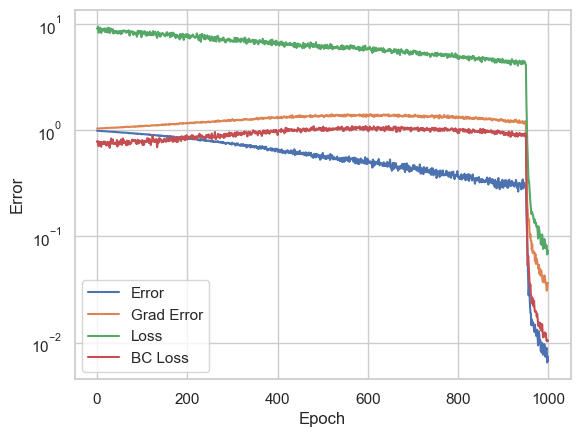

In [11]:
plot_errors_from_data(errors, grad_errors, losses, BC_losses)

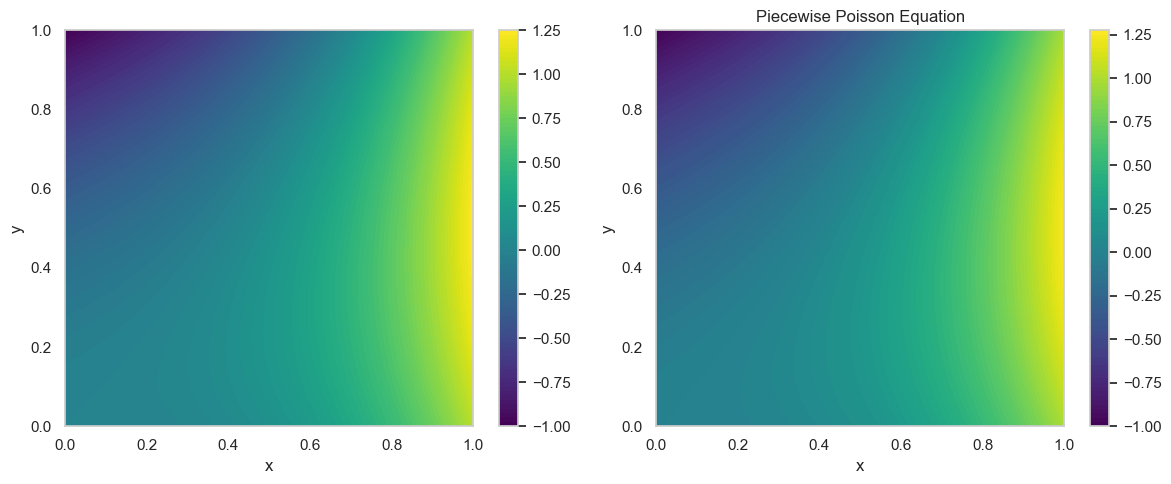

In [12]:
plot_model_vs_analytical_contour(model_piecewise, "Piecewise Poisson Equation")